# Tutorial 04: Clustering, Perceptrons, and Convolutional Neural Networks

**Release Date:** 17 March 2025

## Overview

In this tutorial, we will be looking at clustering, perceptrons, and convolutional neural networks.

### Required Files

* `tut04.ipynb` (i.e., this notebook)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
sns.set_theme()

In [3]:
RANDOM_SEED = 42

## Section 1: k-Means Clustering

In this section, we will be covering k-means clustering with both `scikit-learn` and implementation of our own `CustomKMeans` class.

Again, we will use the iris dataset to understand this concept.

In [4]:
iris_df = load_iris(as_frame=True)['frame'] 
iris_df.head(5)
#iris dataset is classified into 3 classes based on the target column (which species the flower belongs to)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Task 1.1: Using `scikit-learn`'s k-Means Clustering

In `scikit-learn`, k-means clustering is done by using the `sklearn.cluster.KMeans` class.

Recall that k-means clustering is done only on the feature columns of the dataset, which means that we have to select which columns to use.

Fortunately, we can do so easily in Pandas:

In [19]:
features = iris_df.drop(columns='target')
target = iris_df['target']

We ensure that we have train and test sets for each:

In [20]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=RANDOM_SEED)

Recall that we ought to "take the elbow" from the goodness function of the clustering.

Hence, let's implement the function `train_model()` below.

In [21]:
def train_model(max_clusters: int = 10, train_features: pd.DataFrame = train_features) -> list[float]:
	scores = []
	#train model for k means, with max_clusters hyperparam, dataframe of features, return list of
	#initialise centroids
	#assign each point to the closest centroid
	#update the centroids to the mean of the points assigned to it
	#repeat until convergence, append to scores list
	#train kmeans model for each number of clusters from 1 to max_clusters
	#inertia in k-means is the sum of squared distances between each training instance and its closest centroid
	for i in range(1, max_clusters + 1):
		kmeans = KMeans(n_clusters=i, random_state=RANDOM_SEED)
		kmeans.fit(train_features)
		scores.append(kmeans.inertia_)
	return scores

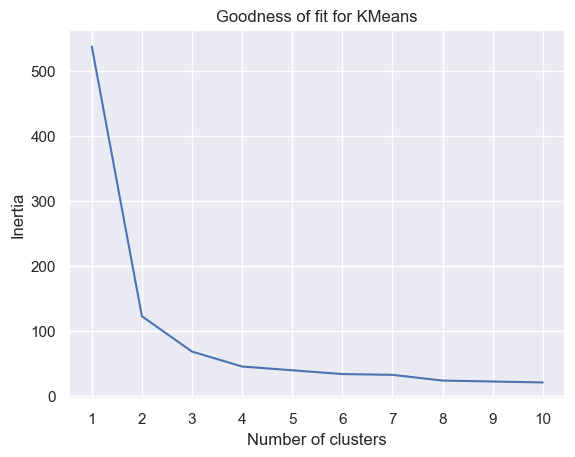

In [22]:
goodness = train_model(max_clusters=10, train_features=train_features)
sns.lineplot(goodness)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Goodness of fit for KMeans")
plt.xticks(ticks=range(0, 10), labels=range(1, 11))
plt.show();

#if k is too high, there is not enough generalisation (each centroid IS a datapoint = didn't learn anything)
#if k is too low, there is too much generalisation (mean of entire dataset without grouping = didn't learn anything)

It seems that the elbow is around 3 clusters, which is the true number of clusters that is present in the dataset.

Hence we retrain the model with 3 clusters.

In [23]:
model = KMeans(n_clusters=3, random_state=RANDOM_SEED)
model.fit(train_features)
train_features["cluster"] = model.predict(train_features)

### Task 1.2: k-Means to Label Mapping

Let's try to equate the clusters to each of the original classes. In order to do this, we will have to know, for each cluster, the number of datapoints for each class label.

In [36]:
#counter represents the number of each target in each cluster
counter = {}
for i in range(len(train_features)):
	cluster = int(train_features["cluster"].iloc[i]) #iloc means integer location, so it's the index of the row
	target = int(train_target.iloc[i])
	if cluster not in counter:
		counter[cluster] = {}
	if target not in counter[cluster]:
		counter[cluster][target] = 0
	counter[cluster][target] += 1

In [37]:
for i in counter:
    print(i, counter[i])

#true is on the left, predicted is on the right

1 {0: 40}
2 {1: 12, 2: 38}
0 {1: 29, 2: 1}


It seems that cluster `2` is equated to label `0`, cluster `1` is equated to label `2`, and cluster `0` is equated to label `1`.

As we can see, the training results are not very accurate. Let's try using `k-means++` as the initialisation method to see whether there are any differences.

In [ ]:
train_features = train_features.drop(columns="cluster")
model = KMeans(n_clusters=3, random_state=RANDOM_SEED, init="k-means++") #difference of k-means++ is that it chooses the initial centroids in a smart way to speed up convergence: first centroid randomly from data points, and then keep choosing the furthest datapoint as the next centroid
model.fit(train_features)
train_features["cluster"] = model.predict(train_features)

In [39]:
counter = {}
for i in range(len(train_features)):
	cluster = int(train_features["cluster"].iloc[i])
	target = int(train_target.iloc[i])
	if cluster not in counter:
		counter[cluster] = {}
	if target not in counter[cluster]:
		counter[cluster][target] = 0
	counter[cluster][target] += 1

In [41]:
for i in counter:
    print(i, counter[i])

1 {0: 40}
2 {1: 12, 2: 38}
0 {1: 29, 2: 1}


Very interesting. It does not appear that the initialisation method changes things for this dataset!

For completeness, we will evaluate the training using the test set.

In [42]:
pred = model.predict(test_features)

Fill in the `mapping` dictionary below with the correct key-value pairs (keys are the cluster indices, values are the actual labels):

In [ ]:
# Fill in the dictionary with the correct mapping
mapping = {0: 1, 1: 0, 2: 2} #correct : predicted

In [44]:
pred = np.array([mapping[p] for p in pred])

In [52]:
print(pred, type(pred))
print(test_target.to_numpy(), type(test_target.to_numpy()))
(pred == test_target.to_numpy()).mean() #value represents the mean of the boolean array, which is the accuracy of the model, with 1 as correct and 0 as incorrect

[1 0 2 1 2 0 1 2 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0] <class 'numpy.ndarray'>
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0] <class 'numpy.ndarray'>


np.float64(0.9333333333333333)

The model performs decently well, with about 0.93 accuracy on the test set.

## Section 2: Perceptrons

In this section, we will cover how to build simple neural networks with PyTorch. 

Again, we will be using the iris dataset to provide a practical example.

In [56]:
iris_df = load_iris(as_frame=True)['frame'] 
iris_df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [57]:
features, target = iris_df.drop(columns='target'), iris_df['target']
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=RANDOM_SEED)

### Task 2.1: Simple Neural Networks with PyTorch

In order to build a simple neural network with PyTorch, there are two key things to do:

1. Create a class inheriting from `torch.nn.Module` (we have shortened the import here to `nn.Module`) and use `super().__init__()` to initialise all the superclass attributes.
2. Create a `forward()` method that takes in some input and returns some output.

Below we give an example neural network.

In [ ]:
class SimpleNN(nn.Module):
	def __init__(self, input_dim: int, output_dim: int):
		# Necessary to include the following line to inherit from nn.Module
		super().__init__()

		# Define the layers of the neural network with linear (feedforward) layers
		self.fc1 = nn.Linear(in_features=input_dim, out_features=64) #matrix multiply input by weights (transposed), add bias, apply activation function
		self.fc2 = nn.Linear(in_features=64, out_features=32)
		self.fc3 = nn.Linear(in_features=32, out_features=output_dim)

		# Define the softmax activation function to output probabilities
		self.softmax = nn.Softmax(dim=1)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		# forward pass of neural network, just pass
		x = self.fc1(x)
		x = self.fc2(x)
		x = self.fc3(x)
		return self.softmax(x)

Now that we've seen how we can make a simple neural network, let's implement one to classify datapoints for the iris dataset.

We'll need to specify the neural network with the following attributes:
1. There will be five linear layers of size (4, 64), (64, 128), (128, 64), (64, 32), and (32, 3).
1. At the end, we will need to have a softmax layer for multiclass classification purposes.

In [ ]:
class IrisNN(nn.Module):
	
	def __init__(self, input_dim:int, output_dim:int):
		super().__init__()

		self.fc1 = nn.Linear(in_features=input_dim, out_features=64) #why no activation function?
		self.fc2 = nn.Linear(in_features=64, out_features=128)
		self.fc3 = nn.Linear(in_features=128, out_features=64)
		self.fc4 = nn.Linear(in_features=64, out_features=32)
		self.fc5 = nn.Linear(in_features=32, out_features=output_dim)

		self.softmax = nn.Softmax(dim=1) #is the last one a layer?

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.fc1(x)
		x = self.fc2(x)
		x = self.fc3(x)
		x = self.fc4(x)
		x = self.fc5(x)
		return self.softmax(x)

In [63]:
iris_model = IrisNN(input_dim=4, output_dim=3)
iris_model

IrisNN(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

By printing the model itself, we can see the entire architecture available to us.

### Task 2.2: Making the PyTorch Training Loop

In order to create the PyTorch training loop, we have to remember the presence of three critical steps in every loop, which have to be written in order:
1. Zero out the gradient with `optimizer.zero_grad()`
1. Predict and retrieve the loss value.
1. Adjust the weights of the model with `optimizer.step()`.

There are other things that one might wish to include -- such as printing the loss value or the training progress -- but these are not always necessary.

You can find out more about this in this link: <https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop>

Let's first define the optimizer and the loss function we are going to use.

In [ ]:
# optimizer is the algorithm that will be used to update the weights of the neural network. Adam is named after the "adaptive moment estimation algorithm"
# criterion is the loss function that will be used to calculate the error of the neural network
optimizer = torch.optim.Adam(iris_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() #CEloss used for classification problems

Other than that, we also have to define a dataloader. This is important as we would like our model to be trained in mini-batches instead of the entire dataset in every inner loop iteration.

The dataloaders are used in order to allow us to (1) load the data partially into memory every time, and (2) allow for customisation of how the dataset will be loaded (e.g., with different batch sizes and/or shuffling).

Observe that the `torch.utils.data.DataLoader` class takes in a `torch.utils.data.TensorDataset`. This refers to a PyTorch map-style dataset (there is also an iterable-style dataset), which means that one is able to get the individual items directly using the `__getitem__()` and `__len__()` methods. The `TensorDataset` class takes PyTorch tensors (which are often the features and the labels). We use the `torch.LongTensor` type for the labels as this is what is accepted by the loss function (`nn.CrossEntropyLoss()`).

Other than that, we define the batch size to use, as well as whether the dataset should be shuffled. The batch size indicates how much of the dataset we would like to use for training and/or testing at any given time, whereas the shuffling indicates whether the datapoints should be shuffled (to prevent the model from learning the ordering of the datapoints to infer information about them). Note that shuffling of the dataset should only be used when training.

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
	torch.utils.data.TensorDataset(torch.tensor(train_features.to_numpy(), dtype=torch.float32), torch.tensor(train_target.to_numpy(), dtype=torch.float32).type(torch.LongTensor)),
	batch_size=16, #only passing thru 16 samples at a time
	shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
	torch.utils.data.TensorDataset(torch.tensor(test_features.to_numpy(), dtype=torch.float32), torch.tensor(test_target.to_numpy(), dtype=torch.float32).type(torch.LongTensor)),
	batch_size=16,
	shuffle=False
)

We are now ready to define the training loop.

In [ ]:
def train_nn(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, epochs: int = 1000):
	# Convert everything to tensors first
	loss_ls = []
	accuracy_ls = []

	for epoch in tqdm(range(epochs)):
		model.train()
		for features, target in train_dataloader:
			optimizer.zero_grad() #set gradients to zero (because in some situations it's not set to 0 between every epoch)
			output = model(features)
			loss = criterion(output, target) #compare output to target using CEloss (see above)
			loss.backward() #backpropagation: see notes
			optimizer.step() #equal to torch.optim.Adam.step() - updates the weights based on the gradients
			

		model.eval()
		with torch.no_grad():
			total_loss = 0
			combined = []
			for features, target in test_dataloader: #evaluate on test dataset
				output = model(features)
				loss = criterion(output, target)
				total_loss += loss.item()
				label_out = torch.argmax(output, dim=1)
				combined.append((label_out, target))
			#calculate accuracy
			accuracy = [accuracy_score(c[0].numpy(), c[1].numpy()) for c in combined]
			loss_ls.append(total_loss / len(test_dataloader))
			accuracy_ls.append(np.mean(accuracy))
			print(f"Epoch {epoch + 1} - Loss: {total_loss / len(test_dataloader)} - Accuracy: {np.mean(accuracy)}")
	return loss_ls, accuracy_ls

In [67]:
loss_ls, accuracy_ls = train_nn(iris_model, train_dataloader, test_dataloader, epochs=200)

  2%|▎         | 5/200 [00:00<00:08, 21.86it/s]

Epoch 1 - Loss: 0.9788652658462524 - Accuracy: 0.7098214285714286
Epoch 2 - Loss: 0.8479128181934357 - Accuracy: 0.7098214285714286
Epoch 3 - Loss: 0.7979453504085541 - Accuracy: 0.7098214285714286
Epoch 4 - Loss: 0.7476432919502258 - Accuracy: 0.7410714285714286
Epoch 5 - Loss: 0.7150647938251495 - Accuracy: 0.8660714285714286
Epoch 6 - Loss: 0.6878995597362518 - Accuracy: 0.8660714285714286
Epoch 7 - Loss: 0.6428139507770538 - Accuracy: 0.9330357142857143


  6%|▋         | 13/200 [00:00<00:06, 29.18it/s]

Epoch 8 - Loss: 0.6163660883903503 - Accuracy: 0.96875
Epoch 9 - Loss: 0.654284656047821 - Accuracy: 0.8660714285714286
Epoch 10 - Loss: 0.6044863164424896 - Accuracy: 0.96875
Epoch 11 - Loss: 0.647271990776062 - Accuracy: 0.8660714285714286
Epoch 12 - Loss: 0.5995690822601318 - Accuracy: 0.96875
Epoch 13 - Loss: 0.6296785771846771 - Accuracy: 0.8973214285714286
Epoch 14 - Loss: 0.5952785313129425 - Accuracy: 0.96875


 10%|█         | 21/200 [00:00<00:05, 31.73it/s]

Epoch 15 - Loss: 0.6686467826366425 - Accuracy: 0.8660714285714286
Epoch 16 - Loss: 0.5913933515548706 - Accuracy: 0.96875
Epoch 17 - Loss: 0.6097491681575775 - Accuracy: 0.96875
Epoch 18 - Loss: 0.6617282032966614 - Accuracy: 0.8660714285714286
Epoch 19 - Loss: 0.659678190946579 - Accuracy: 0.8705357142857143
Epoch 20 - Loss: 0.6639623045921326 - Accuracy: 0.8660714285714286
Epoch 21 - Loss: 0.6299959421157837 - Accuracy: 0.9017857142857143


 14%|█▍        | 29/200 [00:00<00:05, 33.62it/s]

Epoch 22 - Loss: 0.6892696022987366 - Accuracy: 0.8660714285714286
Epoch 23 - Loss: 0.6891535222530365 - Accuracy: 0.8392857142857143
Epoch 24 - Loss: 0.5852774679660797 - Accuracy: 0.96875
Epoch 25 - Loss: 0.6654049754142761 - Accuracy: 0.8660714285714286
Epoch 26 - Loss: 0.6424379944801331 - Accuracy: 0.9017857142857143
Epoch 27 - Loss: 0.6773787438869476 - Accuracy: 0.8660714285714286
Epoch 28 - Loss: 0.5825196802616119 - Accuracy: 0.96875
Epoch 29 - Loss: 0.6179738342761993 - Accuracy: 0.8973214285714286


 16%|█▋        | 33/200 [00:01<00:05, 32.32it/s]

Epoch 30 - Loss: 0.6090687215328217 - Accuracy: 0.9642857142857143
Epoch 31 - Loss: 0.5831727683544159 - Accuracy: 0.96875
Epoch 32 - Loss: 0.5896385014057159 - Accuracy: 0.96875
Epoch 33 - Loss: 0.5839078426361084 - Accuracy: 0.96875
Epoch 34 - Loss: 0.603868842124939 - Accuracy: 0.9330357142857143
Epoch 35 - Loss: 0.5841964483261108 - Accuracy: 0.96875
Epoch 36 - Loss: 0.5917606055736542 - Accuracy: 0.96875


 20%|██        | 41/200 [00:01<00:04, 32.15it/s]

Epoch 37 - Loss: 0.58339723944664 - Accuracy: 0.96875
Epoch 38 - Loss: 0.5944956839084625 - Accuracy: 0.96875
Epoch 39 - Loss: 0.5839892625808716 - Accuracy: 0.96875
Epoch 40 - Loss: 0.6516295373439789 - Accuracy: 0.8973214285714286
Epoch 41 - Loss: 0.5833483040332794 - Accuracy: 0.96875
Epoch 42 - Loss: 0.6231369972229004 - Accuracy: 0.9017857142857143
Epoch 43 - Loss: 0.5875363051891327 - Accuracy: 0.96875


 24%|██▍       | 49/200 [00:01<00:04, 32.76it/s]

Epoch 44 - Loss: 0.5959804356098175 - Accuracy: 0.96875
Epoch 45 - Loss: 0.6039254665374756 - Accuracy: 0.96875
Epoch 46 - Loss: 0.584286093711853 - Accuracy: 0.96875
Epoch 47 - Loss: 0.5863482356071472 - Accuracy: 0.96875
Epoch 48 - Loss: 0.5913510620594025 - Accuracy: 0.96875
Epoch 49 - Loss: 0.6151657402515411 - Accuracy: 0.9330357142857143
Epoch 50 - Loss: 0.6697853207588196 - Accuracy: 0.8660714285714286
Epoch 51 - Loss: 0.583254337310791 - Accuracy: 0.96875


 28%|██▊       | 57/200 [00:01<00:04, 32.10it/s]

Epoch 52 - Loss: 0.5831329822540283 - Accuracy: 0.96875
Epoch 53 - Loss: 0.6993869543075562 - Accuracy: 0.8660714285714286
Epoch 54 - Loss: 0.6100024580955505 - Accuracy: 0.9330357142857143
Epoch 55 - Loss: 0.5905937850475311 - Accuracy: 0.96875
Epoch 56 - Loss: 0.583222508430481 - Accuracy: 0.96875
Epoch 57 - Loss: 0.5881507992744446 - Accuracy: 0.96875
Epoch 58 - Loss: 0.5830661356449127 - Accuracy: 0.96875


 32%|███▎      | 65/200 [00:02<00:04, 32.07it/s]

Epoch 59 - Loss: 0.6061415076255798 - Accuracy: 0.9330357142857143
Epoch 60 - Loss: 0.5829728543758392 - Accuracy: 0.96875
Epoch 61 - Loss: 0.5884634256362915 - Accuracy: 0.96875
Epoch 62 - Loss: 0.5884580612182617 - Accuracy: 0.96875
Epoch 63 - Loss: 0.5896877944469452 - Accuracy: 0.96875
Epoch 64 - Loss: 0.6582110226154327 - Accuracy: 0.8973214285714286
Epoch 65 - Loss: 0.5829335451126099 - Accuracy: 0.96875


 34%|███▍      | 69/200 [00:02<00:03, 33.69it/s]

Epoch 66 - Loss: 0.5970261096954346 - Accuracy: 0.96875
Epoch 67 - Loss: 0.583191454410553 - Accuracy: 0.96875
Epoch 68 - Loss: 0.6108054220676422 - Accuracy: 0.9330357142857143
Epoch 69 - Loss: 0.5829251110553741 - Accuracy: 0.96875
Epoch 70 - Loss: 0.609440416097641 - Accuracy: 0.9330357142857143
Epoch 71 - Loss: 0.5837139785289764 - Accuracy: 0.96875
Epoch 72 - Loss: 0.5841141045093536 - Accuracy: 0.96875


 38%|███▊      | 77/200 [00:02<00:03, 31.96it/s]

Epoch 73 - Loss: 0.6013690531253815 - Accuracy: 0.96875
Epoch 74 - Loss: 0.5829538702964783 - Accuracy: 0.96875
Epoch 75 - Loss: 0.644223153591156 - Accuracy: 0.8660714285714286
Epoch 76 - Loss: 0.6421281397342682 - Accuracy: 0.8660714285714286
Epoch 77 - Loss: 0.5847401022911072 - Accuracy: 0.96875
Epoch 78 - Loss: 0.587579220533371 - Accuracy: 0.96875
Epoch 79 - Loss: 0.5836918950080872 - Accuracy: 0.96875


 42%|████▎     | 85/200 [00:02<00:03, 31.12it/s]

Epoch 80 - Loss: 0.5839133262634277 - Accuracy: 0.96875
Epoch 81 - Loss: 0.6129865050315857 - Accuracy: 0.9330357142857143
Epoch 82 - Loss: 0.5835200846195221 - Accuracy: 0.96875
Epoch 83 - Loss: 0.6609870791435242 - Accuracy: 0.8973214285714286
Epoch 84 - Loss: 0.5835117399692535 - Accuracy: 0.96875
Epoch 85 - Loss: 0.5995820760726929 - Accuracy: 0.96875
Epoch 86 - Loss: 0.5828201770782471 - Accuracy: 0.96875


 46%|████▋     | 93/200 [00:02<00:03, 31.30it/s]

Epoch 87 - Loss: 0.5879927277565002 - Accuracy: 0.96875
Epoch 88 - Loss: 0.5828298032283783 - Accuracy: 0.96875
Epoch 89 - Loss: 0.6659657955169678 - Accuracy: 0.8660714285714286
Epoch 90 - Loss: 0.5828514993190765 - Accuracy: 0.96875
Epoch 91 - Loss: 0.6445691883563995 - Accuracy: 0.8660714285714286
Epoch 92 - Loss: 0.5829344093799591 - Accuracy: 0.96875
Epoch 93 - Loss: 0.6182290017604828 - Accuracy: 0.9330357142857143


 48%|████▊     | 97/200 [00:03<00:03, 31.85it/s]

Epoch 94 - Loss: 0.6628713011741638 - Accuracy: 0.8660714285714286
Epoch 95 - Loss: 0.6194854378700256 - Accuracy: 0.9330357142857143
Epoch 96 - Loss: 0.582844465970993 - Accuracy: 0.96875
Epoch 97 - Loss: 0.6638262271881104 - Accuracy: 0.8660714285714286
Epoch 98 - Loss: 0.6147848665714264 - Accuracy: 0.9330357142857143
Epoch 99 - Loss: 0.6025526821613312 - Accuracy: 0.96875
Epoch 100 - Loss: 0.7216002643108368 - Accuracy: 0.8303571428571428


 52%|█████▎    | 105/200 [00:03<00:02, 31.82it/s]

Epoch 101 - Loss: 0.5828018188476562 - Accuracy: 0.96875
Epoch 102 - Loss: 0.6039057970046997 - Accuracy: 0.96875
Epoch 103 - Loss: 0.59450364112854 - Accuracy: 0.96875
Epoch 104 - Loss: 0.5833491384983063 - Accuracy: 0.96875
Epoch 105 - Loss: 0.590501457452774 - Accuracy: 0.96875
Epoch 106 - Loss: 0.5837050378322601 - Accuracy: 0.96875
Epoch 107 - Loss: 0.6274684369564056 - Accuracy: 0.9330357142857143
Epoch 108 - Loss: 0.5871431827545166 - Accuracy: 0.96875


 56%|█████▋    | 113/200 [00:03<00:02, 32.84it/s]

Epoch 109 - Loss: 0.5849490463733673 - Accuracy: 0.96875
Epoch 110 - Loss: 0.5827675759792328 - Accuracy: 0.96875
Epoch 111 - Loss: 0.6076920032501221 - Accuracy: 0.9330357142857143
Epoch 112 - Loss: 0.5832870006561279 - Accuracy: 0.96875
Epoch 113 - Loss: 0.6332831680774689 - Accuracy: 0.9017857142857143
Epoch 114 - Loss: 0.5840520560741425 - Accuracy: 0.96875
Epoch 115 - Loss: 0.5832373797893524 - Accuracy: 0.96875


 60%|██████    | 121/200 [00:03<00:02, 32.38it/s]

Epoch 116 - Loss: 0.5837880373001099 - Accuracy: 0.96875
Epoch 117 - Loss: 0.5827926695346832 - Accuracy: 0.96875
Epoch 118 - Loss: 0.5916368365287781 - Accuracy: 0.96875
Epoch 119 - Loss: 0.6741293668746948 - Accuracy: 0.8660714285714286
Epoch 120 - Loss: 0.5827845633029938 - Accuracy: 0.96875
Epoch 121 - Loss: 0.5831060111522675 - Accuracy: 0.96875
Epoch 122 - Loss: 0.5827155113220215 - Accuracy: 0.96875


 64%|██████▍   | 129/200 [00:04<00:02, 32.42it/s]

Epoch 123 - Loss: 0.6660797297954559 - Accuracy: 0.8660714285714286
Epoch 124 - Loss: 0.5828209221363068 - Accuracy: 0.96875
Epoch 125 - Loss: 0.583949476480484 - Accuracy: 0.96875
Epoch 126 - Loss: 0.5860086977481842 - Accuracy: 0.96875
Epoch 127 - Loss: 0.6778920888900757 - Accuracy: 0.8660714285714286
Epoch 128 - Loss: 0.5836410224437714 - Accuracy: 0.96875
Epoch 129 - Loss: 0.6731225550174713 - Accuracy: 0.8660714285714286


 66%|██████▋   | 133/200 [00:04<00:02, 32.19it/s]

Epoch 130 - Loss: 0.6467028260231018 - Accuracy: 0.9017857142857143
Epoch 131 - Loss: 0.582793116569519 - Accuracy: 0.96875
Epoch 132 - Loss: 0.5948469042778015 - Accuracy: 0.96875
Epoch 133 - Loss: 0.5827388763427734 - Accuracy: 0.96875
Epoch 134 - Loss: 0.5847206711769104 - Accuracy: 0.96875


 70%|███████   | 141/200 [00:04<00:01, 30.17it/s]

Epoch 135 - Loss: 0.6768111884593964 - Accuracy: 0.8660714285714286
Epoch 136 - Loss: 0.582737922668457 - Accuracy: 0.96875
Epoch 137 - Loss: 0.6008406579494476 - Accuracy: 0.96875
Epoch 138 - Loss: 0.5828543603420258 - Accuracy: 0.96875
Epoch 139 - Loss: 0.5833824276924133 - Accuracy: 0.96875
Epoch 140 - Loss: 0.5830977857112885 - Accuracy: 0.96875
Epoch 141 - Loss: 0.6829943954944611 - Accuracy: 0.8660714285714286


 72%|███████▎  | 145/200 [00:04<00:01, 30.90it/s]

Epoch 142 - Loss: 0.5827952921390533 - Accuracy: 0.96875
Epoch 143 - Loss: 0.5827665627002716 - Accuracy: 0.96875
Epoch 144 - Loss: 0.6117938458919525 - Accuracy: 0.9330357142857143
Epoch 145 - Loss: 0.5829282104969025 - Accuracy: 0.96875
Epoch 146 - Loss: 0.5830592811107635 - Accuracy: 0.96875
Epoch 147 - Loss: 0.5846399366855621 - Accuracy: 0.96875
Epoch 148 - Loss: 0.5828584432601929 - Accuracy: 0.96875
Epoch 149 - Loss: 0.5829498171806335 - Accuracy: 0.96875


 76%|███████▋  | 153/200 [00:04<00:01, 31.29it/s]

Epoch 150 - Loss: 0.583113968372345 - Accuracy: 0.96875
Epoch 151 - Loss: 0.582962840795517 - Accuracy: 0.96875
Epoch 152 - Loss: 0.5830596089363098 - Accuracy: 0.96875
Epoch 153 - Loss: 0.6560175716876984 - Accuracy: 0.8660714285714286
Epoch 154 - Loss: 0.5827582776546478 - Accuracy: 0.96875
Epoch 155 - Loss: 0.6031920611858368 - Accuracy: 0.96875
Epoch 156 - Loss: 0.617752194404602 - Accuracy: 0.9330357142857143


 80%|████████  | 161/200 [00:05<00:01, 31.18it/s]

Epoch 157 - Loss: 0.5827744007110596 - Accuracy: 0.96875
Epoch 158 - Loss: 0.5920595824718475 - Accuracy: 0.96875
Epoch 159 - Loss: 0.6864392757415771 - Accuracy: 0.8660714285714286
Epoch 160 - Loss: 0.5829842984676361 - Accuracy: 0.96875
Epoch 161 - Loss: 0.6148961782455444 - Accuracy: 0.9330357142857143
Epoch 162 - Loss: 0.6817750036716461 - Accuracy: 0.8660714285714286
Epoch 163 - Loss: 0.6814914643764496 - Accuracy: 0.8660714285714286


 84%|████████▍ | 169/200 [00:05<00:00, 31.48it/s]

Epoch 164 - Loss: 0.5828463435173035 - Accuracy: 0.96875
Epoch 165 - Loss: 0.5831047296524048 - Accuracy: 0.96875
Epoch 166 - Loss: 0.5831018090248108 - Accuracy: 0.96875
Epoch 167 - Loss: 0.5828700959682465 - Accuracy: 0.96875
Epoch 168 - Loss: 0.5830510258674622 - Accuracy: 0.96875
Epoch 169 - Loss: 0.5828762948513031 - Accuracy: 0.96875
Epoch 170 - Loss: 0.5827969908714294 - Accuracy: 0.96875


 88%|████████▊ | 177/200 [00:05<00:00, 30.85it/s]

Epoch 171 - Loss: 0.5830181241035461 - Accuracy: 0.96875
Epoch 172 - Loss: 0.5829341113567352 - Accuracy: 0.96875
Epoch 173 - Loss: 0.582910418510437 - Accuracy: 0.96875
Epoch 174 - Loss: 0.5827891230583191 - Accuracy: 0.96875
Epoch 175 - Loss: 0.5828209221363068 - Accuracy: 0.96875
Epoch 176 - Loss: 0.5828479826450348 - Accuracy: 0.96875
Epoch 177 - Loss: 0.5828966796398163 - Accuracy: 0.96875


 90%|█████████ | 181/200 [00:05<00:00, 30.77it/s]

Epoch 178 - Loss: 0.5829287469387054 - Accuracy: 0.96875
Epoch 179 - Loss: 0.5827973484992981 - Accuracy: 0.96875
Epoch 180 - Loss: 0.5827710330486298 - Accuracy: 0.96875
Epoch 181 - Loss: 0.5828076004981995 - Accuracy: 0.96875
Epoch 182 - Loss: 0.582917720079422 - Accuracy: 0.96875
Epoch 183 - Loss: 0.5829283893108368 - Accuracy: 0.96875
Epoch 184 - Loss: 0.5827683210372925 - Accuracy: 0.96875


 94%|█████████▍| 189/200 [00:06<00:00, 30.88it/s]

Epoch 185 - Loss: 0.5827923119068146 - Accuracy: 0.96875
Epoch 186 - Loss: 0.582850992679596 - Accuracy: 0.96875
Epoch 187 - Loss: 0.5827414691448212 - Accuracy: 0.96875
Epoch 188 - Loss: 0.5827934741973877 - Accuracy: 0.96875
Epoch 189 - Loss: 0.5828794836997986 - Accuracy: 0.96875
Epoch 190 - Loss: 0.5827919840812683 - Accuracy: 0.96875
Epoch 191 - Loss: 0.5828421413898468 - Accuracy: 0.96875


 98%|█████████▊| 196/200 [00:06<00:00, 29.52it/s]

Epoch 192 - Loss: 0.5828203558921814 - Accuracy: 0.96875
Epoch 193 - Loss: 0.5828509330749512 - Accuracy: 0.96875
Epoch 194 - Loss: 0.5827691853046417 - Accuracy: 0.96875
Epoch 195 - Loss: 0.5828280746936798 - Accuracy: 0.96875
Epoch 196 - Loss: 0.5827936232089996 - Accuracy: 0.96875
Epoch 197 - Loss: 0.5827683210372925 - Accuracy: 0.96875


100%|██████████| 200/200 [00:06<00:00, 31.17it/s]

Epoch 198 - Loss: 0.5827574133872986 - Accuracy: 0.96875
Epoch 199 - Loss: 0.5828702747821808 - Accuracy: 0.96875
Epoch 200 - Loss: 0.5827786922454834 - Accuracy: 0.96875


We then proceed to visualise our test loss and accuracy over the training epochs.

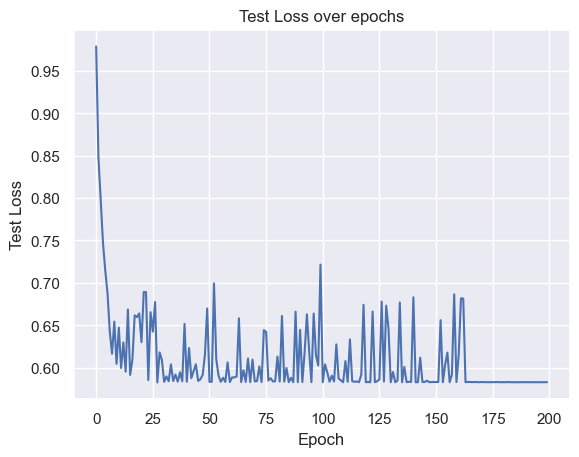

In [68]:
sns.lineplot(loss_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss over epochs")
plt.show();

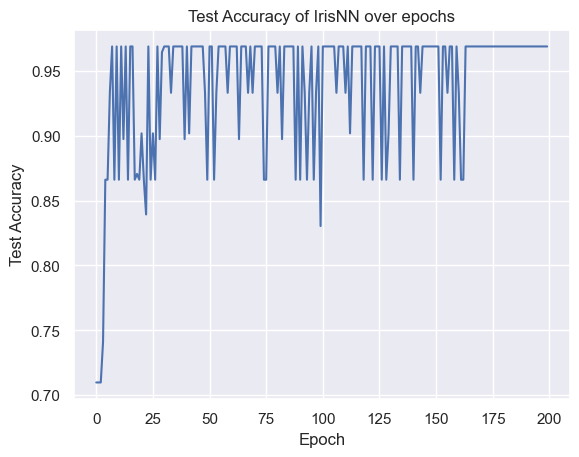

In [69]:
sns.lineplot(accuracy_ls)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of IrisNN over epochs")
plt.show();

It seems that the model has trained quite well, as we are seeing a decrease in the test loss that stabilises over time. We are also seeing that the model has predicted the datapoints within the test set with good accuracy.

## Section 3: Convolutional Neural Networks

We now move on to convolutional neural networks (CNNs), which are mostly used for vision-based tasks (e.g., object detection). We will only be going through simple examples using the MNIST dataset.

This dataset is a dataset containing grayscale images of digits and their respective classes. There are some arguments one is able to pass to the `MNIST` class, such as:
1. `root`: Indicates where in the working directory to store the data into
1. `train`: Whether to use the training set or the testing set
1. `download`: Whether to download the dataset
1. `transform`: Transformations to be done on the dataset (one usually wants the dataset in a tensor format, so we use `ToTensor()` here).

In [4]:
train_mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_mnist_dataloader = torch.utils.data.DataLoader(train_mnist, batch_size=16, shuffle=True)

test_mnist = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=torchvision.transforms.ToTensor())
test_mnist_dataloader = torch.utils.data.DataLoader(test_mnist, batch_size=16, shuffle=False)

If you are unable to download the datasets (on Mac) you can do this:
1. Head to `/Applications/Python 3.12`
2. Double click on the `Install Certificates.command` file and allow it to run

We can see the first sample used by using the following command:

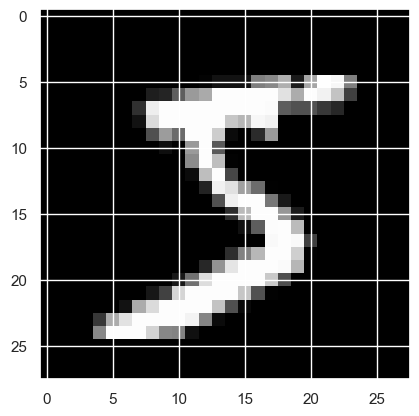

5

In [5]:
plt.imshow(train_mnist[0][0].squeeze(), cmap="gray")
plt.show();
train_mnist[0][1]

As seen above, we display what appears to be a digit `5` as well as the ground truth, which is indeed the digit `5`.

### Task 3.1: Simple CNNs in PyTorch

Similar to normal neural networks, we can use CNNs to predict the class of an image.

However, there are some additional things that we need to take care of, including the use of `nn.Conv2d()` and `nn.MaxPool2d()` layers instead of only using `nn.Linear()` layers.

Complete the `SimpleCNN` class below.

In [6]:
class SimpleCNN(nn.Module):
	def __init__(self, output_dim: int = 10):
		super().__init__()

		self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
		self.maxpool1 = nn.MaxPool2d(kernel_size=3)
		self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
		self.maxpool2 = nn.MaxPool2d(kernel_size=3)
		self.fc1 = nn.Linear(in_features=256, out_features=128)
		self.fc2 = nn.Linear(in_features=128, out_features=output_dim)
		self.softmax = nn.Softmax(dim=1)
	
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.conv1(x)
		x = self.maxpool1(x)
		x = torch.relu(x)

		x = self.conv2(x)
		x = self.maxpool2(x)
		x = torch.relu(x)

		x = torch.flatten(x, 1) #flatten the tensor? Prepares data for the fully connected layers:
		# Convolutional layers output 3D tensors: (batch_size, channels, height, width).
		# Fully connected layers expect 2D tensors: (batch_size, features).

		x = self.fc1(x)
		x=torch.relu(x)

		x = self.fc2(x)
		return x #no softmax here because CrossEntropyLoss does it for us

### Task 3.2: CNN Training Loop

As with the simple neural network, we ought to also design the training loop for the CNN. The difference here is that we would like to use GPU accelerators whenever possible, so we have to set the `device` where we will train the model and send the data accordingly.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
cnn = SimpleCNN(output_dim=10)
cnn

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [9]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

We now define the training loop for the CNN. This will be largely similar to the neural network training loop as seen before.

In [10]:
def train_cnn(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, epochs: int = 1000):
	# Convert everything to tensors first
	loss_ls = []
	accuracy_ls = []
	model = model.to(device)
	

	for epoch in tqdm(range(epochs)):
		model.train()
		for features, target in train_dataloader:
			features, target = features.to(device), target.to(device)
			optimizer.zero_grad()
			output = model(features)
			loss = criterion(output, target)
			loss.backward()
			optimizer.step()
			

		model.eval()
		with torch.no_grad():
			total_loss = 0
			combined = []
			for features, target in test_dataloader:
				features, target = features.to(device), target.to(device)
				output = model(features)
				loss = criterion(output, target)
				total_loss += loss.item()
				label_out = torch.argmax(output, dim=1) #argmax returns the index of the maximum value in the tensor
				combined.append((label_out, target))
				
			accuracy = [accuracy_score(c[0].cpu().numpy(), c[1].cpu().numpy()) for c in combined]
			loss_ls.append(total_loss / len(test_dataloader))
			accuracy_ls.append(np.mean(accuracy))
			print(f"Epoch {epoch + 1} - Loss: {total_loss / len(test_dataloader)} - Accuracy: {np.mean(accuracy)}")
	return loss_ls, accuracy_ls

In [ ]:
train_cnn(cnn, train_mnist_dataloader, test_mnist_dataloader, epochs=20)

  5%|▌         | 1/20 [00:18<05:53, 18.59s/it]

Epoch 1 - Loss: 0.16626636821739377 - Accuracy: 0.9486


 10%|█         | 2/20 [00:36<05:27, 18.20s/it]

Epoch 2 - Loss: 0.1397326469244901 - Accuracy: 0.9592


 15%|█▌        | 3/20 [00:54<05:08, 18.12s/it]

Epoch 3 - Loss: 0.14179706015150295 - Accuracy: 0.9609


 20%|██        | 4/20 [01:12<04:51, 18.25s/it]

Epoch 4 - Loss: 0.15216233045857808 - Accuracy: 0.9596


 25%|██▌       | 5/20 [01:31<04:34, 18.29s/it]

Epoch 5 - Loss: 0.14816980123305692 - Accuracy: 0.9584


 30%|███       | 6/20 [01:49<04:15, 18.24s/it]

Epoch 6 - Loss: 0.17673243864249089 - Accuracy: 0.9558


 35%|███▌      | 7/20 [02:07<03:56, 18.21s/it]

Epoch 7 - Loss: 0.13175150774237118 - Accuracy: 0.9655


 40%|████      | 8/20 [02:25<03:38, 18.21s/it]

Epoch 8 - Loss: 0.13772127797110878 - Accuracy: 0.9636


 45%|████▌     | 9/20 [02:44<03:20, 18.21s/it]

Epoch 9 - Loss: 0.1647244223466143 - Accuracy: 0.9571


 50%|█████     | 10/20 [03:02<03:01, 18.18s/it]

Epoch 10 - Loss: 0.27753347671501033 - Accuracy: 0.938


 55%|█████▌    | 11/20 [03:20<02:44, 18.24s/it]

Epoch 11 - Loss: 0.12709192003823408 - Accuracy: 0.9711


 60%|██████    | 12/20 [03:38<02:26, 18.29s/it]

Epoch 12 - Loss: 0.11859638647164393 - Accuracy: 0.969


 65%|██████▌   | 13/20 [03:57<02:07, 18.28s/it]

Epoch 13 - Loss: 0.1388843514318578 - Accuracy: 0.9637


 70%|███████   | 14/20 [04:15<01:49, 18.17s/it]

Epoch 14 - Loss: 0.12850705703232962 - Accuracy: 0.9681


 75%|███████▌  | 15/20 [04:33<01:31, 18.28s/it]

Epoch 15 - Loss: 0.12394252769221785 - Accuracy: 0.9682


 80%|████████  | 16/20 [04:52<01:13, 18.34s/it]

Epoch 16 - Loss: 0.14577878102939013 - Accuracy: 0.9648


 85%|████████▌ | 17/20 [05:10<00:54, 18.32s/it]

Epoch 17 - Loss: 0.14099000940592232 - Accuracy: 0.9666


We see that the model training has proceeded very well, achieving more than 99% test accuracy after only 10 iterations.

### Task 3.3: Conclusion

What are some things that you've learnt from this tutorial? Are there any interesting observations that you have made?

Write your thoughts in the cell below.

**Write your thoughts here:**